PARTE VI

A.- El reto aquí es transformar un formato "ancho" (días como columnas) a "largo" (tidy data) y hacer los joins correctos sin explotar la memoria.

In [5]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt

from mlforecast import MLForecast
from mlforecast.lag_transforms import RollingMean, RollingStd
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re

import kagglehub
from kagglehub import KaggleDatasetAdapter

import geopandas as gpd
from shapely.geometry import Point
from sklearn.neighbors import BallTree


# Configurar semillas globales
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [6]:
# 1. Carga de datos (asumiendo que los archivos están en la carpeta local)
# Nota: En un entorno real, usarías paths específicos
calendar = pd.read_csv('calendar.csv')
sales = pd.read_csv('sales_train_evaluation.csv')
prices = pd.read_csv('sell_prices.csv')

# 2. Filtrado inicial según requerimientos
# Departamento: "FOODS_3" | Tiendas: CA_1, CA_2, CA_3, CA_4
stores_ca = ['CA_1', 'CA_2', 'CA_3', 'CA_4']
df_sales = sales[(sales['dept_id'] == 'FOODS_3') &
                 (sales['store_id'].isin(stores_ca))].copy()

# 3. Transformación de formato "Ancho" a "Largo" (Melt)
# Seleccionamos columnas de identificación y los días d_1 a d_1900
id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
day_cols = [f'd_{i}' for i in range(1, 1901)] # Período de entrenamiento d_1 a d_1900

df_melted = df_sales.melt(id_vars=id_vars,
                          value_vars=day_cols,
                          var_name='d',
                          value_name='y')

# 4. Preparación de variables exógenas en Calendar [cite: 77]
calendar['date'] = pd.to_datetime(calendar['date'])
# is_event: Binaria si hay evento en event_name_1 o event_name_2
calendar['is_event'] = calendar[['event_name_1', 'event_name_2']].notna().any(axis=1).astype(int)
# is_weekend: Sábado (wday 1) y Domingo (wday 2) según formato M5
calendar['is_weekend'] = calendar['wday'].isin([1, 2]).astype(int)

# 5. Merges para consolidar el Dataset [cite: 77]
# Merge con Calendar para obtener fechas y variables temporales
df_final = df_melted.merge(calendar[['d', 'date', 'snap_CA', 'is_event', 'is_weekend', 'wday', 'wm_yr_wk']],
                           on='d',
                           how='left')

# Merge con Prices (usando item_id, store_id y wm_yr_wk)
df_final = df_final.merge(prices,
                          on=['item_id', 'store_id', 'wm_yr_wk'],
                          how='left')

# 6. Formateo Final para MLForecast [cite: 76, 77]
# unique_id: Combinación tienda-familia (usamos 'id' que ya viene como item_store)
# ds: Fecha en datetime
# y: Ventas
df_mlf = df_final.rename(columns={
    'id': 'unique_id',
    'date': 'ds',
    'wday': 'day_of_week',
    'sell_price': 'sell_price'
})

# Seleccionamos solo las columnas necesarias según el enunciado
columns_to_keep = ['unique_id', 'ds', 'y', 'is_event', 'snap_CA', 'sell_price', 'day_of_week', 'is_weekend']
df_mlf = df_mlf[columns_to_keep].sort_values(['unique_id', 'ds'])

# Visualización del resultado
print("Head del DataFrame resultante para MLForecast:")
print(df_mlf.head())

Head del DataFrame resultante para MLForecast:
                         unique_id         ds  y  is_event  snap_CA  \
0      FOODS_3_001_CA_1_evaluation 2011-01-29  1         0        0   
3292   FOODS_3_001_CA_1_evaluation 2011-01-30  1         0        0   
6584   FOODS_3_001_CA_1_evaluation 2011-01-31  1         0        0   
9876   FOODS_3_001_CA_1_evaluation 2011-02-01  1         0        1   
13168  FOODS_3_001_CA_1_evaluation 2011-02-02  1         0        1   

       sell_price  day_of_week  is_weekend  
0            2.28            1           1  
3292         2.28            2           1  
6584         2.28            3           0  
9876         2.28            4           0  
13168        2.28            5           0  


B.- Configuramos un modelo global capaz de aprender patrones cruzados entre series, utilizando retardos y ventanas móviles para capturar la inercia de las ventas.

In [7]:
# 1. Definición de los modelos a entrenar
models = [
    LGBMRegressor(random_state=42, n_jobs=-1),
    XGBRegressor(random_state=42, n_jobs=-1)
]

# 2. Configuración del Pipeline de MLForecast
fcst = MLForecast(
    models=models,
    freq='D',  # Frecuencia diaria
    lags=[1, 7, 14, 28],  # Lags solicitados
    lag_transforms={
        1: [
            RollingMean(window_size=7),   # Media móvil 7 días [cite: 88]
            RollingMean(window_size=14),  # Media móvil 14 días [cite: 88]
            RollingStd(window_size=7)     # Desviación estándar 7 días [cite: 89]
        ]
    },
    date_features=['day', 'dayofyear', 'week'], # día mes, día año, semana año
)

# 3. Definición de variables exógenas
# Estas variables ya vienen en el DataFrame del punto (a) y se usarán en el entrenamiento
static_features = [] # En este caso no definimos estáticas adicionales, todo es dinámico
dynamic_features = ['is_event', 'snap_CA', 'sell_price', 'day_of_week', 'is_weekend']

# 4. Entrenamiento (Fit)
# Usamos el dataframe df_mlf preparado en la parte (a)
print("Iniciando el entrenamiento de LightGBM y XGBoost...")
fcst.fit(
    df_mlf,
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    static_features=static_features
)

print("¡Entrenamiento completado exitosamente! [cite: 92]")

Iniciando el entrenamiento de LightGBM y XGBoost...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.163061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1771
[LightGBM] [Info] Number of data points in the train set: 6162624, number of used features: 15
[LightGBM] [Info] Start training from score 2.208611
¡Entrenamiento completado exitosamente! [cite: 92]


C.- Generamos el forecast para los 13 días de prueba y evaluamos la precisión mediante métricas de error estándar.

Generando predicciones para el horizonte de 13 días...

--- Resultados de Evaluación ---
               MAE      RMSE      MAPE
LightGBM  1.495863  2.648205  0.529062
XGBoost   1.464724  2.709694  0.548478


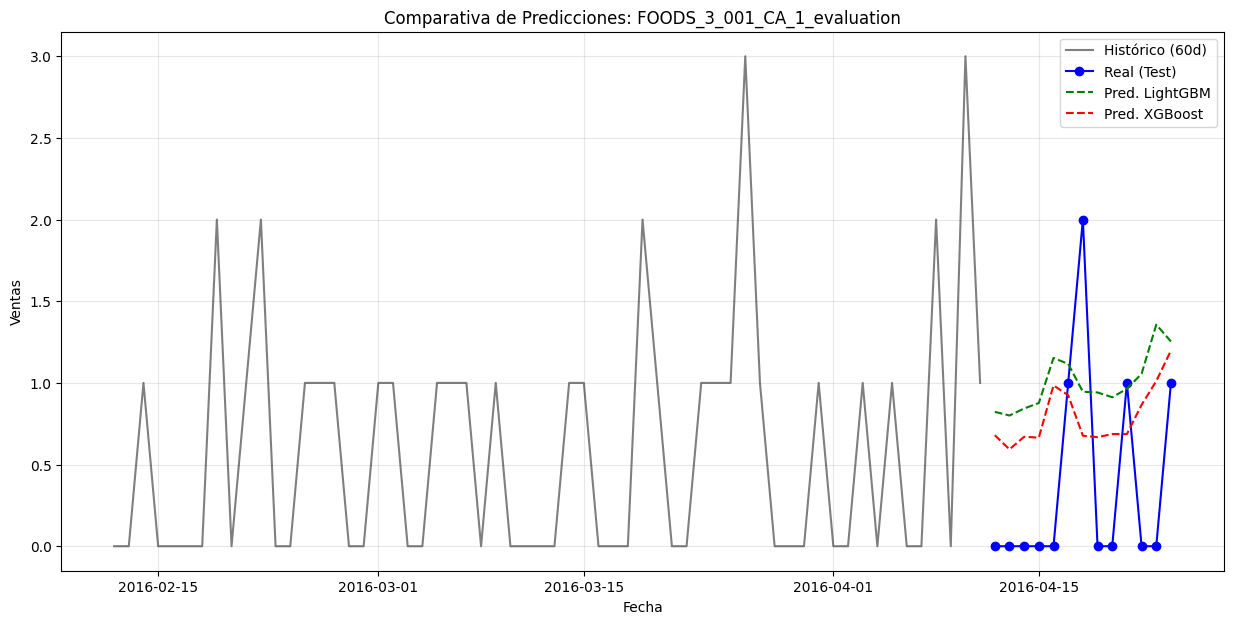

In [8]:
# 1. Crear un mapeo de unique_id a item_id y store_id
# Esto es necesario porque el dataframe de precios no conoce el "unique_id"
id_map = sales[['id', 'item_id', 'store_id']].drop_duplicates()
id_map = id_map.rename(columns={'id': 'unique_id'})

# 2. Preparación de X_df (Variables exógenas para el horizonte de predicción)
test_days = [f'd_{i}' for i in range(1901, 1914)]

# Filtramos el calendario para los días de test
horizon_dates = calendar[calendar['d'].isin(test_days)][['d', 'date', 'wday', 'wm_yr_wk', 'snap_CA', 'is_event', 'is_weekend']]
horizon_dates['date'] = pd.to_datetime(horizon_dates['date'])

# Creamos la estructura base: cada unique_id para cada fecha del horizonte
unique_ids = df_mlf['unique_id'].unique()
X_df = pd.DataFrame({'unique_id': unique_ids}).merge(horizon_dates, how='cross')

# --- AQUÍ ESTÁ LA CORRECCIÓN ---
# Unimos con el mapa de IDs para tener 'item_id' y 'store_id' antes del merge con precios
X_df = X_df.merge(id_map, on='unique_id', how='left')

# Ahora sí podemos traer los precios
X_df = X_df.merge(prices, on=['item_id', 'store_id', 'wm_yr_wk'], how='left')
# -------------------------------

# Renombramos y seleccionamos columnas finales
X_df = X_df.rename(columns={
    'date': 'ds',
    'wday': 'day_of_week',
    'sell_price': 'sell_price'
})[['unique_id', 'ds', 'is_event', 'snap_CA', 'sell_price', 'day_of_week', 'is_weekend']]

# 3. Generar Predicciones
print("Generando predicciones para el horizonte de 13 días...")
preds = fcst.predict(h=13, X_df=X_df)

# 4. Obtener el Ground Truth (Valores reales d_1901 a d_1913)
df_real = sales[sales['id'].isin(unique_ids)].melt(
    id_vars=['id'],
    value_vars=test_days,
    var_name='d',
    value_name='y_true'
)
df_real = df_real.merge(calendar[['d', 'date']], on='d')
df_real['date'] = pd.to_datetime(df_real['date'])
df_real = df_real.rename(columns={'id': 'unique_id', 'date': 'ds'})

# 5. Consolidar Predicciones y Reales
res_eval = preds.merge(df_real[['unique_id', 'ds', 'y_true']], on=['unique_id', 'ds'], how='left')

# 6. Cálculo de Métricas
def calculate_metrics(df, model_name):
    y_true = df['y_true']
    y_pred = df[model_name]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mask = y_true > 0
    mape = mean_absolute_percentage_error(y_true[mask], y_pred[mask]) if any(mask) else np.nan
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

metrics_lgbm = calculate_metrics(res_eval, 'LGBMRegressor')
metrics_xgb = calculate_metrics(res_eval, 'XGBRegressor')

# 7. Mostrar Resultados
df_metrics = pd.DataFrame([metrics_lgbm, metrics_xgb], index=['LightGBM', 'XGBoost'])
print("\n--- Resultados de Evaluación ---")
print(df_metrics)


# Visualización final solicitada en el punto c)
plt.figure(figsize=(15, 7))

# Filtramos un ejemplo (un item-tienda específico) para visualizar
example_id = res_eval['unique_id'].unique()[0]
df_plot_train = df_mlf[df_mlf['unique_id'] == example_id].tail(60)
df_plot_test = res_eval[res_eval['unique_id'] == example_id]

# Plotear histórico (60 días)
plt.plot(df_plot_train['ds'], df_plot_train['y'], label='Histórico (60d)', color='black', alpha=0.5)

# Plotear valores reales
plt.plot(df_plot_test['ds'], df_plot_test['y_true'], label='Real (Test)', color='blue', marker='o')

# Plotear predicciones
plt.plot(df_plot_test['ds'], df_plot_test['LGBMRegressor'], label='Pred. LightGBM', linestyle='--', color='green')
plt.plot(df_plot_test['ds'], df_plot_test['XGBRegressor'], label='Pred. XGBoost', linestyle='--', color='red')

plt.title(f'Comparativa de Predicciones: {example_id}')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('comparativa_forecast_m5.png')
plt.show()

C:\Users\Chris\AppData\Local\Temp\ipykernel_22584\2078297239.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=lgbm_importance.head(10), palette='viridis')


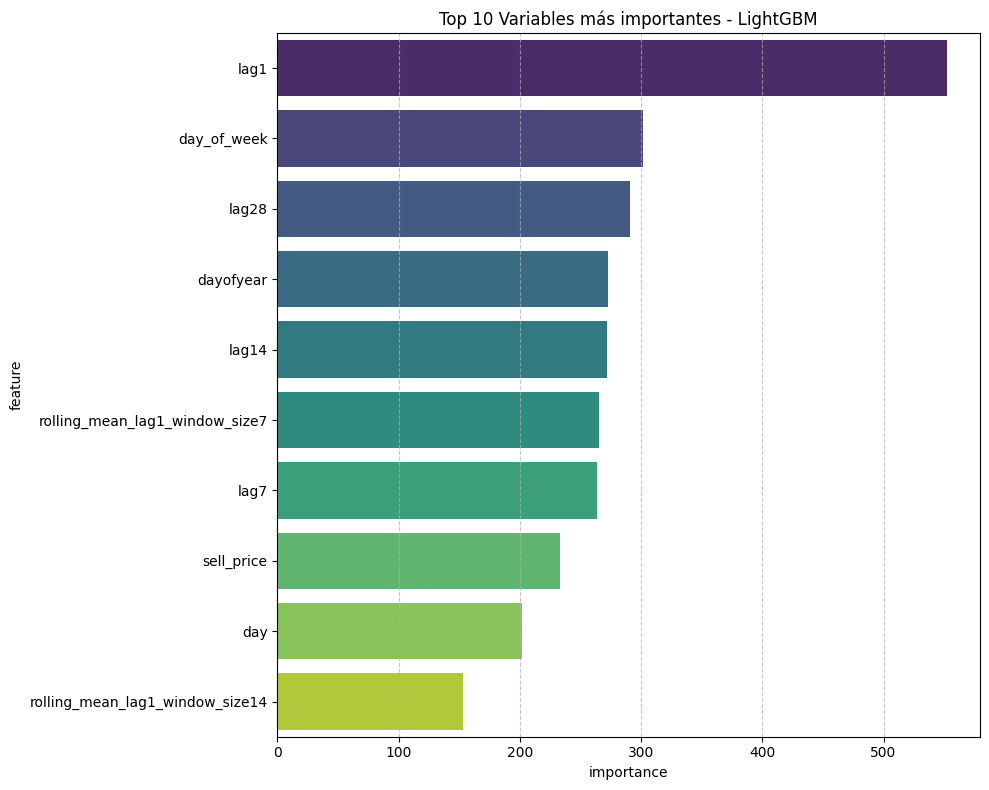


--- RESUMEN DE IMPORTANCIA DE VARIABLES ---
Top 3 LightGBM: lag1, day_of_week, lag28


In [9]:
# 1. Extraer modelos del objeto MLForecast
lgbm_model = fcst.models_['LGBMRegressor']

# 2. Obtener nombres de features de forma robusta
# LightGBM y XGBoost (versiones recientes) guardan los nombres en 'feature_name_' o 'feature_names_in_'
lgbm_features = lgbm_model.feature_name_

# 3. Crear DataFrames de importancia
lgbm_importance = pd.DataFrame({
    'feature': lgbm_features,
    'importance': lgbm_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# 4. Visualización
plt.figure(figsize=(10, 8))

# Subplot 1: LightGBM
sns.barplot(x='importance', y='feature', data=lgbm_importance.head(10), palette='viridis')
plt.title('Top 10 Variables más importantes - LightGBM')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('feature_importance_walmart.png')
plt.show()

# 5. Breve reporte de hallazgos
print("\n--- RESUMEN DE IMPORTANCIA DE VARIABLES ---")
print(f"Top 3 LightGBM: {', '.join(lgbm_importance['feature'].head(3).tolist())}")


PARTE V

Primero, limpiamos el ruido. En e-commerce, las devoluciones y los precios erróneos pueden arruinar cualquier modelo de regresión.

In [10]:
import pandas as pd
import numpy as np

# 1. Carga eficiente del dataset
# Nota: Si el archivo está en formato ZIP, pandas lo descomprime automáticamente
df = pd.read_csv('online_retail_II.csv')

# 2. Limpieza según requerimientos del proyecto
df = df[df['Country'] == 'United Kingdom']
df = df[(df['Quantity'] > 0) & (~df['Invoice'].astype(str).str.startswith('C'))]
df = df[(df['Price'] > 0) & (df['Customer ID'].notnull())]

# 3. Identificar los 10 productos más vendidos (Top 10)
top_10_items = df.groupby('StockCode')['Quantity'].sum().nlargest(10).index.tolist()
df_top = df[df['StockCode'].isin(top_10_items)].copy()

# 4. Agregación semanal
df_top['InvoiceDate'] = pd.to_datetime(df_top['InvoiceDate'])
# Creamos una columna para el inicio de la semana (Lunes)
df_top['week'] = df_top['InvoiceDate'].dt.to_period('W').dt.to_timestamp()

df_weekly = df_top.groupby(['StockCode', 'Description', 'week']).agg(
    cantidad_total=('Quantity', 'sum'),
    precio_promedio=('Price', 'mean'),
    n_transacciones=('Invoice', 'count')
).reset_index()

# 5. Generación del Entregable 5a con Estilo (reemplaza a print)
resumen_top10 = df_weekly.groupby(['StockCode', 'Description'])['cantidad_total'].sum().reset_index()

# Aplicar formato visual
entregable_estilizado = resumen_top10.style \
    .set_caption("Entregable 5a: Top 10 Productos Seleccionados (Reino Unido)") \
    .format({'cantidad_total': '{:,.0f}'}) \
    .background_gradient(cmap='YlGn', subset=['cantidad_total']) \
    .set_properties(**{'text-align': 'center', 'font-family': 'Arial'}) \
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#2c3e50'), ('color', 'white'), ('font-weight', 'bold')]}
    ])

# Mostrar la tabla (en Jupyter/Colab solo necesitas llamar al objeto)
entregable_estilizado

,StockCode,Description,cantidad_total
0,17003,BROCADE RING PURSE,"70,725"
1,21212,PACK OF 72 RETRO SPOT CAKE CASES,"35,347"
2,21212,PACK OF 72 RETROSPOT CAKE CASES,"32,143"
3,21977,PACK OF 60 PINK PAISLEY CAKE CASES,"45,454"
4,22197,POPCORN HOLDER,"28,935"
5,22197,"POPCORN HOLDER , SMALL","2,831"
6,22197,SMALL POPCORN HOLDER,"40,001"
7,23166,MEDIUM CERAMIC TOP STORAGE JAR,"76,919"
8,23843,"PAPER CRAFT , LITTLE BIRDIE","80,995"
9,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,"100,720"


b) Estimación de elasticidad Naive (Log-Log)

La elasticidad se estima con un modelo Log-Log porque el coeficiente β representa directamente el cambio porcentual en Q ante un cambio de 1% en P.

In [11]:
import statsmodels.formula.api as smf
import warnings
import numpy as np
import pandas as pd

results_list = []

for code in top_10_items:
    data_prod = df_weekly[df_weekly['StockCode'] == code].copy()
    
    # 1. Validación de varianza: Si el precio es siempre el mismo, la regresión fallará
    if data_prod['precio_promedio'].nunique() <= 1:
        # Opcional: imprimir qué producto se salta para saber por qué no aparece
        # print(f"Saltando {code}: Precio constante, no se puede calcular elasticidad.")
        continue

    # 2. Aplicar logaritmos
    data_prod['ln_q'] = np.log(data_prod['cantidad_total'])
    data_prod['ln_p'] = np.log(data_prod['precio_promedio'])
    
    # 3. Regresión OLS silenciando warnings específicos de división por cero
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        try:
            model = smf.ols('ln_q ~ ln_p', data=data_prod).fit()
            
            desc = data_prod['Description'].iloc[0]
            results_list.append({
                'StockCode': code,
                'Description': desc[:30],
                'beta': model.params['ln_p'],
                'p_value': model.pvalues['ln_p'],
                'R2': model.rsquared
            })
        except:
            continue

results_df = pd.DataFrame(results_list)

# 4. Mostrar resultados con estilo (reemplazando el print plano)
if not results_df.empty:
    display(results_df.style.set_caption("Resultados de Elasticidad Precio").format({'beta': '{:.2f}', 'p_value': '{:.4f}', 'R2': '{:.3f}'}))
    
    # Análisis de resultados
    significativos = results_df[results_df['p_value'] < 0.05]
    elasticos = significativos[significativos['beta'].abs() > 1]
    print(f"\nAnálisis Final:")
    print(f"- Productos analizados con éxito: {len(results_df)}")
    print(f"- Productos estadísticamente significativos (p < 0.05): {len(significativos)}")
    print(f"- Productos elásticos (|beta| > 1): {len(elasticos)}")
else:
    print("No se pudieron procesar productos. Verifica que haya variación en los precios.")

,StockCode,Description,beta,p_value,R2
0,84077,WORLD WAR 2 GLIDERS ASSTD DESI,0.09,0.8681,0.000
1,85123A,CREAM HANGING HEART T-LIGHT HO,-17.58,0.0000,0.168
2,85099B,JUMBO BAG RED RETROSPOT,1.17,0.7333,0.001
3,23166,MEDIUM CERAMIC TOP STORAGE JAR,-23.71,0.0000,0.540
4,84879,ASSORTED COLOUR BIRD ORNAMENT,-30.06,0.0001,0.147
5,22197,POPCORN HOLDER,-3.96,0.3655,0.007
6,17003,BROCADE RING PURSE,-0.91,0.1187,0.026
7,21212,PACK OF 72 RETRO SPOT CAKE CAS,-11.58,0.0000,0.204
8,21977,PACK OF 60 PINK PAISLEY CAKE C,-10.85,0.0000,0.192



Análisis Final:
- Productos analizados con éxito: 9
- Productos estadísticamente significativos (p < 0.05): 5
- Productos elásticos (|beta| > 1): 5


c) Modelo con efectos temporales

Aquí corregimos el sesgo de que "en Navidad se vende más aunque el precio suba". Usaremos variables dummy para meses y productos.

Análisis de Endogeneidad: La inclusión de efectos temporales suele aumentar el valor absoluto de la elasticidad (hacerla más negativa). Sin ellos, el modelo ve que en diciembre los precios suben y las ventas también (por la Navidad), lo que haría parecer que la elasticidad es positiva o "inelástica". Al controlar por el mes, el modelo compara los precios dentro de la misma temporada, revelando la verdadera sensibilidad del cliente.

In [12]:
import pandas as pd
from IPython.display import display, HTML

# --- Tu modelo (sin cambios) ---
df_panel = df_weekly.copy()
df_panel['ln_q'] = np.log(df_panel['cantidad_total'])
df_panel['ln_p'] = np.log(df_panel['precio_promedio'])
df_panel['month'] = df_panel['week'].dt.month.astype(str)

model_panel = smf.ols('ln_q ~ ln_p + C(StockCode) + C(month)', data=df_panel).fit()

# --- MEJORA DE LA SALIDA ---

# 1. Extraer métricas clave
beta_pooled = model_panel.params['ln_p']
se_pooled = model_panel.bse['ln_p']  # Error estándar
p_value = model_panel.pvalues['ln_p']
r2_adj = model_panel.rsquared_adj
avg_beta_ind = results_df['beta'].mean()

# 2. Crear tabla comparativa para Notebook
df_comparativo = pd.DataFrame({
    'Metodología': ['Modelo de Panel (Efectos Fijos)', 'Media de Regresiones Individuales'],
    'Elasticidad (β)': [beta_pooled, avg_beta_ind],
    'Error Estándar': [se_pooled, results_df['beta'].std() / np.sqrt(len(results_df))],
    'Interpretación': [
        "Elástica" if abs(beta_pooled) > 1 else "Inelástica",
        "Elástica" if abs(avg_beta_ind) > 1 else "Inelástica"
    ]
})

# 3. Formato visual
print("\n" + "═"*70)
print(f" {'REPORTE DE CONSOLIDACIÓN: ELASTICIDAD PRECIO-DEMANDA':^68} ")
print("═"*70)

# Mostramos el resumen técnico del modelo de panel
display(df_comparativo.style.format({
    'Elasticidad (β)': '{:.4f}',
    'Error Estándar': '{:.4f}'
}).set_properties(**{'text-align': 'center'}) \
  .background_gradient(cmap='coolwarm', subset=['Elasticidad (β)']))

# 4. Bloque de Conclusión de Negocio
print("\n" + "─"*70)
print(f" RESULTADOS CLAVE DEL MODELO POOLED:")
print(f" • Coeficiente Beta (Elasticidad): {beta_pooled:.4f}")
print(f" • Significancia Estadística:     {'SÍ (p < 0.05)' if p_value < 0.05 else 'NO'}")
print(f" • Poder Explicativo (R² Adj.):   {r2_adj:.2%}")
print("─"*70)

# Interpretación dinámica
if beta_pooled < 0:
    impacto = "Un aumento del 10% en el precio reduciría la demanda en un {:.1f}%.".format(abs(beta_pooled) * 10)
else:
    impacto = "Se observa una relación inusual positiva (posible efecto de marca o stock)."

print(f" INSIGHT ESTRATÉGICO:\n {impacto}")
print("═"*70 + "\n")


══════════════════════════════════════════════════════════════════════
         REPORTE DE CONSOLIDACIÓN: ELASTICIDAD PRECIO-DEMANDA         
══════════════════════════════════════════════════════════════════════


,Metodología,Elasticidad (β),Error Estándar,Interpretación
0,Modelo de Panel (Efectos Fijos),-1.6978,0.3622,Elástica
1,Media de Regresiones Individuales,-10.8208,3.7097,Elástica



──────────────────────────────────────────────────────────────────────
 RESULTADOS CLAVE DEL MODELO POOLED:
 • Coeficiente Beta (Elasticidad): -1.6978
 • Significancia Estadística:     SÍ (p < 0.05)
 • Poder Explicativo (R² Adj.):   20.54%
──────────────────────────────────────────────────────────────────────
 INSIGHT ESTRATÉGICO:
 Un aumento del 10% en el precio reduciría la demanda en un 17.0%.
══════════════════════════════════════════════════════════════════════



PARTE VII

#### Datos

In [14]:
# 1. Carga de datos
file_path = 'Precios_PS03.xlsx'
df = pd.read_excel(file_path, sheet_name='Estudiantes-train-test')
df_target = pd.read_excel(file_path, sheet_name='Estudiantes-target')


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10060 entries, 0 to 10059
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   titulo_propiedad  10060 non-null  int64  
 1   precio_uf         10060 non-null  float64
 2   dormitorios       4901 non-null   float64
 3   banhos            4207 non-null   float64
 4   area              4660 non-null   float64
 5   mantenimiento     8268 non-null   float64
 6   antiguedad        3463 non-null   float64
 7   estacionamientos  3058 non-null   float64
 8   piso              2471 non-null   float64
 9   latitud           10060 non-null  float64
 10  longitud          10060 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 864.7 KB


In [16]:
df

,titulo_propiedad,precio_uf,dormitorios,banhos,area,mantenimiento,antiguedad,estacionamientos,piso,latitud,longitud
0,1,2292.0,2.0,2.0,NaN,NaN,2.0,NaN,3.0,53.079296,8.801694
1,2,3405.0,3.0,1.0,78.0,NaN,NaN,NaN,NaN,39.198199,-2.143135
2,3,1395.0,3.0,3.0,58.0,NaN,NaN,1.0,NaN,-70.589747,-33.561335
3,4,3800.0,2.0,1.0,60.0,95.0,13.0,1.0,7.0,-22.278790,-68.323950
4,5,4800.0,3.0,2.0,NaN,NaN,NaN,1.0,NaN,-22.432726,-68.911713
...,...,...,...,...,...,...,...,...,...,...,...
10055,10056,2800.0,NaN,NaN,NaN,60.0,NaN,NaN,NaN,-36.825568,-73.063159
10056,10057,2700.0,NaN,NaN,NaN,60.0,NaN,NaN,NaN,-36.826864,-73.063784
10057,10058,4950.0,2.0,NaN,70.0,135.0,NaN,NaN,NaN,31.286378,-113.474348
10058,10059,3683.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.802610,-116.419389


In [17]:
df_target

,titulo_propiedad,dormitorios,banhos,area,mantenimiento,antiguedad,estacionamientos,piso,latitud,longitud
0,10060,3.0,2.0,61.0,NaN,0.0,1.0,NaN,-0.001759,-0.038881
1,10061,NaN,NaN,NaN,80.00,NaN,NaN,NaN,-22.442250,-68.901803
2,10062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-22.433957,-68.911234
3,10063,1.0,1.0,27.0,36.85,5.0,NaN,NaN,-22.440803,-68.921938
4,10064,1.0,1.0,28.0,55.00,20.0,NaN,1.0,-22.440784,-68.922034
...,...,...,...,...,...,...,...,...,...,...
2514,12574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-36.824677,-73.051342
2515,12575,NaN,NaN,NaN,110.00,NaN,NaN,NaN,-36.833206,-73.053591
2516,12576,2.0,2.0,NaN,NaN,NaN,NaN,NaN,-12.085869,-77.016327
2517,12577,2.0,2.0,62.0,100.00,0.0,1.0,NaN,8.969789,-79.534567


In [18]:
# Filtro sugerido para la Región Metropolitana aproximado
df = df[(df['latitud'] < -32.55) & (df['latitud'] > -34.19) &
        (df['longitud'] < -69.46) & (df['longitud'] > -71.43)]

df_target = df_target[(df_target['latitud'] < -32.55) & (df_target['latitud'] > -34.19) &
        (df_target['longitud'] < -69.46) & (df_target['longitud'] > -71.43)]

In [19]:
# 1. Cargar el mapa de comunas
mapa_comunas = gpd.read_file('comunas.geojson')

mapa_comunas



,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry
0,48,170038.6241,16,8,6204,6,9.685774e+08,206184.2716,Región del Libertador Bernardo O'Higgins,Marchigüe,Cardenal Caro,"POLYGON ((-71.8007 -34.2072, -71.7295 -34.3146..."
1,29,125730.1047,15,8,6102,6,4.157446e+08,151911.5768,Región del Libertador Bernardo O'Higgins,Codegua,Cachapoal,"POLYGON ((-70.3529 -33.9526, -70.3276 -34.0103..."
2,30,63026.0844,15,8,6103,6,1.448565e+08,76355.3261,Región del Libertador Bernardo O'Higgins,Coinco,Cachapoal,"POLYGON ((-70.9005 -34.237, -70.8704 -34.2681,..."
3,31,89840.9035,15,8,6104,6,3.256572e+08,108874.6231,Región del Libertador Bernardo O'Higgins,Coltauco,Cachapoal,"POLYGON ((-71.0249 -34.1705, -70.9657 -34.1761..."
4,78,122626.4932,23,11,9121,9,6.990727e+08,156680.4106,Región de La Araucanía,Cholchol,Cautín,"POLYGON ((-72.9589 -38.4687, -72.9212 -38.4925..."
...,...,...,...,...,...,...,...,...,...,...,...,...
341,255,130240.5558,19,10,16305,16,8.751006e+08,160459.1379,Región de Ñuble,San Nicolás,Punilla,"POLYGON ((-72.242 -36.3522, -72.0513 -36.4192,..."
342,253,311061.9324,19,10,16304,16,2.393007e+09,388109.6138,Región de Ñuble,San Fabián,Punilla,"POLYGON ((-71.2483 -36.4559, -71.2249 -36.4626..."
343,245,159257.9064,19,10,16303,16,7.638173e+08,195593.9337,Región de Ñuble,Ñiquén,Punilla,"POLYGON ((-72.099 -36.1371, -72.0754 -36.1311,..."
344,243,157467.0496,19,10,16104,16,1.044405e+09,196962.6643,Región de Ñuble,El Carmen,Ñuble,"POLYGON ((-71.7422 -36.8288, -71.6045 -36.9016..."


In [20]:
mapa_metro = gpd.read_file('Estaciones_actuales_Metro_de_Santiago.geojson')
mapa_metro

,FID,objectid,id,especial,estacion,nombre,temporal,f1,tipo,linea,geometry
0,1,1,1,EXISTENTE INTERMODAL,EXISTENTE,SAN PABLO,INTERMODAL,1,ESTACION METRO,Linea 1,POINT (-70.72329 -33.44419)
1,2,2,2,EXISTENTE,EXISTENTE,NEPTUNO,,1,ESTACION METRO,Linea 1,POINT (-70.72254 -33.45193)
2,3,3,3,EXISTENTE INTERMODAL,EXISTENTE,PAJARITOS,INTERMODAL,1,ESTACION METRO,Linea 1,POINT (-70.7134 -33.45783)
3,4,4,4,EXISTENTE,EXISTENTE,LAS REJAS,,1,ESTACION METRO,Linea 1,POINT (-70.70647 -33.45724)
4,5,5,5,CONSTRUCCION INTERMODAL,CONSTRUCCION,QUINTA NORMAL,INTERMODAL,1,ESTACION METRO,Linea 5,POINT (-70.68007 -33.44034)
...,...,...,...,...,...,...,...,...,...,...,...
112,113,0,113,EXISTENTE,EXISTENTE,LO PRADO,,0,ESTACION METRO,Linea 5,POINT (-70.71574 -33.44311)
113,114,0,114,EXISTENTE,EXISTENTE,GRUTA DE LOURDES,,0,ESTACION METRO,Linea 5,POINT (-70.69119 -33.43809)
114,115,0,115,EXISTENTE,EXISTENTE,BLANQUEADO,,0,ESTACION METRO,Linea 5,POINT (-70.70718 -33.44144)
115,116,0,116,EXISTENTE,EXISTENTE,PUDAHUEL,,0,ESTACION METRO,Linea 5,POINT (-70.74065 -33.44473)


In [21]:
def assign_comuna(dataframe, lat_col, lon_col, comunas_gdf):
    # Convert DataFrame to GeoDataFrame
    geometry = [Point(xy) for xy in zip(dataframe[lon_col], dataframe[lat_col])]
    gdf_properties = gpd.GeoDataFrame(dataframe, geometry=geometry, crs=comunas_gdf.crs)

    # Perform spatial join
    # Updated 'op' to 'predicate' for compatibility with modern GeoPandas
    properties_with_comuna = gpd.sjoin_nearest(
          gdf_properties,
          mapa_comunas[['Comuna', 'geometry']],
          how='left',
          distance_col="dist_comuna"
          )

    # Drop the 'index_right' column and the geometry (if you want to return a standard DF)
    properties_with_comuna = properties_with_comuna.drop(columns=['index_right', 'geometry'])

    return properties_with_comuna

# Apply the function to df and df_target
df = assign_comuna(df, 'latitud', 'longitud', mapa_comunas)
df_target = assign_comuna(df_target, 'latitud', 'longitud', mapa_comunas)

print("df with 'Comuna' column:")
display(df.head())

print("\ndf_target with 'Comuna' column:")
display(df_target.head())

c:\Users\Chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\array.py:407: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
c:\Users\Chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\array.py:407: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


df with 'Comuna' column:


,titulo_propiedad,precio_uf,dormitorios,banhos,area,mantenimiento,antiguedad,estacionamientos,piso,latitud,longitud,Comuna,dist_comuna
79,80,4500.0,NaN,NaN,NaN,50.0,NaN,NaN,NaN,-33.261657,-70.231476,Lo Barnechea,0.0
80,81,11900.0,3.0,2.0,91.0,NaN,10.0,1.0,6.0,-33.354397,-70.248839,Lo Barnechea,0.0
81,82,5500.0,NaN,NaN,NaN,200.0,NaN,NaN,NaN,-33.355221,-70.248879,Lo Barnechea,0.0
82,83,8300.0,NaN,NaN,NaN,100.0,NaN,NaN,NaN,-33.353849,-70.248932,Lo Barnechea,0.0
83,84,5500.0,NaN,NaN,NaN,180.0,NaN,NaN,NaN,-33.356235,-70.249010,Lo Barnechea,0.0



df_target with 'Comuna' column:


,titulo_propiedad,dormitorios,banhos,area,mantenimiento,antiguedad,estacionamientos,piso,latitud,longitud,Comuna,dist_comuna
26,10086,NaN,NaN,NaN,150.0,NaN,NaN,NaN,-33.334288,-70.290197,Lo Barnechea,0.0
27,10087,5.0,4.0,110.0,450.0,36.0,2.0,NaN,-33.335965,-70.290960,Lo Barnechea,0.0
28,10088,NaN,NaN,NaN,200.0,NaN,NaN,NaN,-33.347934,-70.291261,Lo Barnechea,0.0
29,10089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-33.336694,-70.291363,Lo Barnechea,0.0
30,10090,4.0,3.0,NaN,140.0,0.0,NaN,NaN,-33.337267,-70.291384,Lo Barnechea,0.0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8417 entries, 79 to 8956
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   titulo_propiedad  8417 non-null   int64  
 1   precio_uf         8417 non-null   float64
 2   dormitorios       3662 non-null   float64
 3   banhos            3142 non-null   float64
 4   area              3497 non-null   float64
 5   mantenimiento     7090 non-null   float64
 6   antiguedad        2683 non-null   float64
 7   estacionamientos  2190 non-null   float64
 8   piso              1945 non-null   float64
 9   latitud           8417 non-null   float64
 10  longitud          8417 non-null   float64
 11  Comuna            8417 non-null   object 
 12  dist_comuna       8417 non-null   float64
dtypes: float64(11), int64(1), object(1)
memory usage: 920.6+ KB


In [23]:
from shapely.ops import nearest_points

def add_metro_distance(df_points, metro_gdf):
    # 1. Convertir el DataFrame a GeoDataFrame si aún no lo es
    if not isinstance(df_points, gpd.GeoDataFrame):
        geometry = [Point(xy) for xy in zip(df_points['longitud'], df_points['latitud'])]
        gdf = gpd.GeoDataFrame(df_points.copy(), geometry=geometry, crs="EPSG:4326")
    else:
        gdf = df_points.copy()

    # 2. Proyectar a metros (EPSG:5361 es ideal para Chile central)
    gdf_meters = gdf.to_crs(epsg=5361)
    metro_meters = metro_gdf.to_crs(epsg=5361)

    # 3. Encontrar la estación más cercana
    # 'distance_col' creará una columna con la distancia en metros
    gdf_with_dist = gpd.sjoin_nearest(
        gdf_meters,
        metro_meters[['geometry']], # Solo necesitamos la geometría para la distancia
        how="left",
        distance_col="distancia_metro"
    )

    # 4. Limpiar columnas extras de sjoin y volver a formato original si es necesario
    if 'index_right' in gdf_with_dist.columns:
        gdf_with_dist = gdf_with_dist.drop(columns=['index_right'])

    return gdf_with_dist

# Aplicación
df = add_metro_distance(df, mapa_metro)

display(df.head())

df_target = add_metro_distance(df_target, mapa_metro)
display(df_target.head())

,titulo_propiedad,precio_uf,dormitorios,banhos,area,mantenimiento,antiguedad,estacionamientos,piso,latitud,longitud,Comuna,dist_comuna,geometry,distancia_metro
79,80,4500.0,NaN,NaN,NaN,50.0,NaN,NaN,NaN,-33.261657,-70.231476,Lo Barnechea,0.0,POINT (385297.877 6319029.015),33373.562816
80,81,11900.0,3.0,2.0,91.0,NaN,10.0,1.0,6.0,-33.354397,-70.248839,Lo Barnechea,0.0,POINT (383803.665 6308727.105),28170.083548
81,82,5500.0,NaN,NaN,NaN,200.0,NaN,NaN,NaN,-33.355221,-70.248879,Lo Barnechea,0.0,POINT (383801.019 6308635.675),28147.193343
82,83,8300.0,NaN,NaN,NaN,100.0,NaN,NaN,NaN,-33.353849,-70.248932,Lo Barnechea,0.0,POINT (383794.208 6308787.75),28174.498651
83,84,5500.0,NaN,NaN,NaN,180.0,NaN,NaN,NaN,-33.356235,-70.249010,Lo Barnechea,0.0,POINT (383790.178 6308523.133),28111.994979


,titulo_propiedad,dormitorios,banhos,area,mantenimiento,antiguedad,estacionamientos,piso,latitud,longitud,Comuna,dist_comuna,geometry,distancia_metro
26,10086,NaN,NaN,NaN,150.0,NaN,NaN,NaN,-33.334288,-70.290197,Lo Barnechea,0.0,POINT (379927.714 6310909.827),25060.120317
27,10087,5.0,4.0,110.0,450.0,36.0,2.0,NaN,-33.335965,-70.290960,Lo Barnechea,0.0,POINT (379858.993 6310723.084),24932.703064
28,10088,NaN,NaN,NaN,200.0,NaN,NaN,NaN,-33.347934,-70.291261,Lo Barnechea,0.0,POINT (379847.421 6309395.601),24511.818584
29,10089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-33.336694,-70.291363,Lo Barnechea,0.0,POINT (379822.496 6310641.824),24871.327934
30,10090,4.0,3.0,NaN,140.0,0.0,NaN,NaN,-33.337267,-70.291384,Lo Barnechea,0.0,POINT (379821.283 6310578.188),24849.233783


In [24]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 8417 entries, 79 to 8956
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   titulo_propiedad  8417 non-null   int64   
 1   precio_uf         8417 non-null   float64 
 2   dormitorios       3662 non-null   float64 
 3   banhos            3142 non-null   float64 
 4   area              3497 non-null   float64 
 5   mantenimiento     7090 non-null   float64 
 6   antiguedad        2683 non-null   float64 
 7   estacionamientos  2190 non-null   float64 
 8   piso              1945 non-null   float64 
 9   latitud           8417 non-null   float64 
 10  longitud          8417 non-null   float64 
 11  Comuna            8417 non-null   object  
 12  dist_comuna       8417 non-null   float64 
 13  geometry          8417 non-null   geometry
 14  distancia_metro   8417 non-null   float64 
dtypes: float64(12), geometry(1), int64(1), object(1)
memory usage: 1.0+ 

In [25]:
import pandas as pd

cols_joyas = ['folio', 'yautcorh', 'esc', 'nse']

# Si el archivo es .dta (formato oficial de MDS)
casen = pd.read_stata('casen_2022.dta', columns=cols_joyas)

casen.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202231 entries, 0 to 202230
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   folio     202231 non-null  int32   
 1   yautcorh  202231 non-null  int32   
 2   esc       165248 non-null  float64 
 3   nse       202231 non-null  category
dtypes: category(1), float64(1), int32(2)
memory usage: 3.3 MB


In [26]:
casen_provincias_comunas = pd.read_stata('casen_2022_provincia_comuna.dta')

casen_provincias_comunas = casen_provincias_comunas[['folio','comuna']].drop_duplicates()
casen_provincias_comunas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72056 entries, 0 to 202228
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   folio   72056 non-null  int32   
 1   comuna  72056 non-null  category
dtypes: category(1), int32(1)
memory usage: 995.9 KB


In [27]:
casen = casen.merge(casen_provincias_comunas[['folio','comuna']],how='left',on='folio')

In [28]:
casen

,folio,yautcorh,esc,nse,comuna
0,100090101,435242,1.0,Bajo-medio,Ñiquén
1,100090101,435242,4.0,Bajo-medio,Ñiquén
2,100090101,435242,15.0,Bajo-medio,Ñiquén
3,100090201,0,NaN,Bajo-medio,Ñiquén
4,100090201,0,12.0,Bajo-medio,Ñiquén
...,...,...,...,...,...
202226,458580401,3400000,NaN,Alto,Temuco
202227,458580401,3400000,17.0,Alto,Temuco
202228,458580701,1000000,15.0,Alto,Temuco
202229,458580701,1000000,NaN,Alto,Temuco


In [29]:
casen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202231 entries, 0 to 202230
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   folio     202231 non-null  int32   
 1   yautcorh  202231 non-null  int32   
 2   esc       165248 non-null  float64 
 3   nse       202231 non-null  category
 4   comuna    202231 non-null  category
dtypes: category(2), float64(1), int32(2)
memory usage: 3.7 MB


In [30]:
casen.describe(include='all')

,folio,yautcorh,esc,nse,comuna
count,2.022310e+05,2.022310e+05,165248.000000,202231,202231
unique,NaN,NaN,NaN,7,335
top,NaN,NaN,NaN,Bajo-medio,Arica
freq,NaN,NaN,NaN,56021,7999
mean,2.781527e+08,1.132364e+06,11.167421,NaN,NaN
std,1.035578e+08,1.390255e+06,4.269671,NaN,NaN
min,1.000901e+08,0.000000e+00,0.000000,NaN,NaN
25%,1.891108e+08,4.220000e+05,8.000000,NaN,NaN
50%,2.770002e+08,8.000000e+05,12.000000,NaN,NaN
75%,3.674905e+08,1.382084e+06,14.000000,NaN,NaN


In [31]:
casen = pd.get_dummies(casen, columns = ['nse'],dtype=int)
casen

,folio,yautcorh,esc,comuna,nse_Bajo,nse_Medio,nse_Alto,nse_Bajo-medio,nse_Bajo-alto,nse_Bajo-medio-alto,nse_Medio-alto
0,100090101,435242,1.0,Ñiquén,0,0,0,1,0,0,0
1,100090101,435242,4.0,Ñiquén,0,0,0,1,0,0,0
2,100090101,435242,15.0,Ñiquén,0,0,0,1,0,0,0
3,100090201,0,NaN,Ñiquén,0,0,0,1,0,0,0
4,100090201,0,12.0,Ñiquén,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
202226,458580401,3400000,NaN,Temuco,0,0,1,0,0,0,0
202227,458580401,3400000,17.0,Temuco,0,0,1,0,0,0,0
202228,458580701,1000000,15.0,Temuco,0,0,1,0,0,0,0
202229,458580701,1000000,NaN,Temuco,0,0,1,0,0,0,0


In [32]:
casen.columns

Index(['folio', 'yautcorh', 'esc', 'comuna', 'nse_Bajo', 'nse_Medio',
       'nse_Alto', 'nse_Bajo-medio', 'nse_Bajo-alto', 'nse_Bajo-medio-alto',
       'nse_Medio-alto'],
      dtype='object')

In [33]:
agg_dict = {
    'yautcorh': 'median',  # Ingreso autónomo corregido del hogar
    'esc': 'median',       # Años de escolaridad (edad >= 15)
}

# Identificamos las columnas que nacieron del get_dummies para aplicarles el promedio
dummy_cols = [
    'nse_Bajo',
    'nse_Medio',
    'nse_Alto',
    'nse_Bajo-medio',
    'nse_Bajo-alto',
    'nse_Bajo-medio-alto',
    'nse_Medio-alto'
]

# Actualizamos el diccionario con las columnas dummy
for col in dummy_cols:
    agg_dict[col] = 'mean'

# Agrupamos por comuna (asegúrate de que 'comuna' sea la columna original)
casen_comunal = casen.groupby('comuna').agg(agg_dict).reset_index()

casen_comunal


C:\Users\Chris\AppData\Local\Temp\ipykernel_22584\4241973414.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  casen_comunal = casen.groupby('comuna').agg(agg_dict).reset_index()


,comuna,yautcorh,esc,nse_Bajo,nse_Medio,nse_Alto,nse_Bajo-medio,nse_Bajo-alto,nse_Bajo-medio-alto,nse_Medio-alto
0,Iquique,1000000.0,12.0,0.108813,0.638655,0.229692,0.022840,0.000000,0.000000,0.000000
1,Alto Hospicio,800000.0,12.0,0.606854,0.000000,0.000000,0.000000,0.000000,0.000000,0.393146
2,Pozo Almonte,800000.0,12.0,0.000000,0.000000,0.000000,0.576497,0.423503,0.000000,0.000000
3,Camiña,750000.0,12.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4,Colchane,200000.0,7.5,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
330,San Carlos,500000.0,11.0,0.230058,0.000000,0.000000,0.381503,0.000000,0.000000,0.388439
331,Coihueco,500000.0,8.0,0.000000,0.000000,0.000000,0.340807,0.000000,0.659193,0.000000
332,Ñiquén,400000.0,9.0,0.144105,0.000000,0.000000,0.855895,0.000000,0.000000,0.000000
333,San Fabián,550000.0,10.0,0.746575,0.000000,0.000000,0.253425,0.000000,0.000000,0.000000


In [34]:
casen_comunal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   comuna               335 non-null    category
 1   yautcorh             335 non-null    float64 
 2   esc                  335 non-null    float64 
 3   nse_Bajo             335 non-null    float64 
 4   nse_Medio            335 non-null    float64 
 5   nse_Alto             335 non-null    float64 
 6   nse_Bajo-medio       335 non-null    float64 
 7   nse_Bajo-alto        335 non-null    float64 
 8   nse_Bajo-medio-alto  335 non-null    float64 
 9   nse_Medio-alto       335 non-null    float64 
dtypes: category(1), float64(9)
memory usage: 35.1 KB


In [35]:
df = df.merge(casen_comunal, how='left',left_on='Comuna',right_on='comuna')
df

,titulo_propiedad,precio_uf,dormitorios,banhos,area,mantenimiento,antiguedad,estacionamientos,piso,latitud,...,comuna,yautcorh,esc,nse_Bajo,nse_Medio,nse_Alto,nse_Bajo-medio,nse_Bajo-alto,nse_Bajo-medio-alto,nse_Medio-alto
0,80,4500.0,NaN,NaN,NaN,50.0,NaN,NaN,NaN,-33.261657,...,Lo Barnechea,2396004.0,14.0,0.000000,0.000000,0.292467,0.673560,0.0,0.0,0.033973
1,81,11900.0,3.0,2.0,91.0,NaN,10.0,1.0,6.0,-33.354397,...,Lo Barnechea,2396004.0,14.0,0.000000,0.000000,0.292467,0.673560,0.0,0.0,0.033973
2,82,5500.0,NaN,NaN,NaN,200.0,NaN,NaN,NaN,-33.355221,...,Lo Barnechea,2396004.0,14.0,0.000000,0.000000,0.292467,0.673560,0.0,0.0,0.033973
3,83,8300.0,NaN,NaN,NaN,100.0,NaN,NaN,NaN,-33.353849,...,Lo Barnechea,2396004.0,14.0,0.000000,0.000000,0.292467,0.673560,0.0,0.0,0.033973
4,84,5500.0,NaN,NaN,NaN,180.0,NaN,NaN,NaN,-33.356235,...,Lo Barnechea,2396004.0,14.0,0.000000,0.000000,0.292467,0.673560,0.0,0.0,0.033973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8412,8953,2150.0,NaN,NaN,NaN,50.0,NaN,NaN,NaN,-33.040457,...,Villa Alemana,902792.0,12.0,0.090067,0.732323,0.132997,0.044613,0.0,0.0,0.000000
8413,8954,1561.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,-33.062089,...,Villa Alemana,902792.0,12.0,0.090067,0.732323,0.132997,0.044613,0.0,0.0,0.000000
8414,8955,2815.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-33.041896,...,Villa Alemana,902792.0,12.0,0.090067,0.732323,0.132997,0.044613,0.0,0.0,0.000000
8415,8956,2290.0,1.0,1.0,NaN,60.0,2.0,NaN,5.0,-33.046041,...,Villa Alemana,902792.0,12.0,0.090067,0.732323,0.132997,0.044613,0.0,0.0,0.000000


In [36]:
df_target = df_target.merge(casen_comunal, how='left',left_on='Comuna',right_on='comuna')
df_target

,titulo_propiedad,dormitorios,banhos,area,mantenimiento,antiguedad,estacionamientos,piso,latitud,longitud,...,comuna,yautcorh,esc,nse_Bajo,nse_Medio,nse_Alto,nse_Bajo-medio,nse_Bajo-alto,nse_Bajo-medio-alto,nse_Medio-alto
0,10086,NaN,NaN,NaN,150.0,NaN,NaN,NaN,-33.334288,-70.290197,...,Lo Barnechea,2396004.0,14.0,0.000000,0.000000,0.292467,0.673560,0.0,0.0,0.033973
1,10087,5.0,4.0,110.0,450.0,36.0,2.0,NaN,-33.335965,-70.290960,...,Lo Barnechea,2396004.0,14.0,0.000000,0.000000,0.292467,0.673560,0.0,0.0,0.033973
2,10088,NaN,NaN,NaN,200.0,NaN,NaN,NaN,-33.347934,-70.291261,...,Lo Barnechea,2396004.0,14.0,0.000000,0.000000,0.292467,0.673560,0.0,0.0,0.033973
3,10089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-33.336694,-70.291363,...,Lo Barnechea,2396004.0,14.0,0.000000,0.000000,0.292467,0.673560,0.0,0.0,0.033973
4,10090,4.0,3.0,NaN,140.0,0.0,NaN,NaN,-33.337267,-70.291384,...,Lo Barnechea,2396004.0,14.0,0.000000,0.000000,0.292467,0.673560,0.0,0.0,0.033973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,12307,3.0,3.0,65.0,NaN,NaN,1.0,NaN,-33.046092,-71.372420,...,Villa Alemana,902792.0,12.0,0.090067,0.732323,0.132997,0.044613,0.0,0.0,0.000000
2075,12308,2.0,2.0,60.0,40.0,0.0,1.0,4.0,-33.042480,-71.373475,...,Villa Alemana,902792.0,12.0,0.090067,0.732323,0.132997,0.044613,0.0,0.0,0.000000
2076,12309,2.0,2.0,60.0,40.0,NaN,NaN,NaN,-33.042471,-71.373572,...,Villa Alemana,902792.0,12.0,0.090067,0.732323,0.132997,0.044613,0.0,0.0,0.000000
2077,12310,2.0,2.0,62.0,50.0,8.0,1.0,5.0,-33.044301,-71.374376,...,Villa Alemana,902792.0,12.0,0.090067,0.732323,0.132997,0.044613,0.0,0.0,0.000000


In [37]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8417 entries, 0 to 8416
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   titulo_propiedad     8417 non-null   int64   
 1   precio_uf            8417 non-null   float64 
 2   dormitorios          3662 non-null   float64 
 3   banhos               3142 non-null   float64 
 4   area                 3497 non-null   float64 
 5   mantenimiento        7090 non-null   float64 
 6   antiguedad           2683 non-null   float64 
 7   estacionamientos     2190 non-null   float64 
 8   piso                 1945 non-null   float64 
 9   latitud              8417 non-null   float64 
 10  longitud             8417 non-null   float64 
 11  Comuna               8417 non-null   object  
 12  dist_comuna          8417 non-null   float64 
 13  geometry             8417 non-null   geometry
 14  distancia_metro      8417 non-null   float64 
 15  comuna       

In [38]:
COSTANERA_LAT, COSTANERA_LON = -33.4172, -70.6064

def haversine(lat1, lon1, lat2, lon2):
    R = 6371 # Radio de la Tierra en km
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c


df['dist_costanera'] = haversine(df['latitud'], df['longitud'], COSTANERA_LAT, COSTANERA_LON)
df_target['dist_costanera'] = haversine(df_target['latitud'], df_target['longitud'], COSTANERA_LAT, COSTANERA_LON)

#### Preprocesamiento

In [39]:
# eliminar columnas constantes
df = df.loc[:, df.nunique() > 1]



In [40]:
df['antiguedad'] = np.where(df['antiguedad']<0,0,df['antiguedad'])

df = df[df['precio_uf']>500]

c:\Users\Chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\geodataframe.py:1969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [41]:
columnas_con_nulos = df.columns[df.isnull().any()].tolist()
columnas_con_nulos

['dormitorios',
 'banhos',
 'area',
 'mantenimiento',
 'antiguedad',
 'estacionamientos',
 'piso']

In [42]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer


cols_a_imputar = ['dormitorios', 'banhos', 'area', 'antiguedad', 'estacionamientos', 'piso','mantenimiento']
contexto = ['latitud', 'longitud', 'yautcorh', 'dist_costanera']

imputer = KNNImputer(n_neighbors=5)
# Aseguramos que yautcorh no tenga nulos antes (llenar con mediana si falta alguno)
df['yautcorh'] = df['yautcorh'].fillna(df['yautcorh'].median())
df_target['yautcorh'] = df_target['yautcorh'].fillna(df['yautcorh'].median())

# Fit en train y transform en ambos
df[cols_a_imputar] = imputer.fit_transform(df[contexto + cols_a_imputar])[:, len(contexto):]
df_target[cols_a_imputar] = imputer.transform(df_target[contexto + cols_a_imputar])[:, len(contexto):]

print(df.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 8415 entries, 0 to 8416
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   titulo_propiedad     8415 non-null   int64   
 1   precio_uf            8415 non-null   float64 
 2   dormitorios          8415 non-null   float64 
 3   banhos               8415 non-null   float64 
 4   area                 8415 non-null   float64 
 5   mantenimiento        8415 non-null   float64 
 6   antiguedad           8415 non-null   float64 
 7   estacionamientos     8415 non-null   float64 
 8   piso                 8415 non-null   float64 
 9   latitud              8415 non-null   float64 
 10  longitud             8415 non-null   float64 
 11  Comuna               8415 non-null   object  
 12  dist_comuna          8415 non-null   float64 
 13  geometry             8415 non-null   geometry
 14  distancia_metro      8415 non-null   float64 
 15  comuna            

In [43]:
for dataset in [df, df_target]:
    # Interacción Área x Ingreso: 1m2 extra vale más en comunas ricas
    dataset['area_income_inter'] = dataset['area'] * dataset['yautcorh']
    # Densidad de habitaciones: ¿Es un depto amplio o uno "estudio"?
    dataset['rooms_per_area'] = (dataset['dormitorios'] + dataset['banhos']) / dataset['area']
    # Interacción Distancia x Ingreso
    dataset['dist_income_inter'] = dataset['dist_costanera'] * dataset['yautcorh']

#### Modelos

In [44]:
features = [col for col in df.columns if col not in ['precio_uf',
                                                     'titulo_propiedad',
                                                     'id',
                                                     'Comuna',
                                                     'geometry']]

X = df[features]
y = df['precio_uf']

# 2. Split inicial
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# --- PASO CLAVE: TARGET ENCODING ---
# Calculamos el promedio de 'precio_uf' por comuna usando SOLO el set de entrenamiento
# Usamos y_train (el target) asociado a X_train['comuna']
comuna_means = y_train.groupby(X_train['comuna']).mean()

# Mapeamos esos valores a ambos sets
X_train['comuna_target_enc'] = X_train['comuna'].map(comuna_means)
X_val['comuna_target_enc'] = X_val['comuna'].map(comuna_means)

# Manejo de valores nulos: Si una comuna en el set de validación NO estaba en el de train,
# el map devolverá NaN. Lo llenamos con el promedio global de train.
global_mean = y_train.mean()
X_train['comuna_target_enc'] = X_train['comuna_target_enc'].fillna(global_mean)
X_val['comuna_target_enc'] = X_val['comuna_target_enc'].fillna(global_mean)

# Ahora eliminamos la columna 'comuna' original (string) para que XGBoost no reclame
X_train = X_train.drop(columns=['comuna'])
X_val = X_val.drop(columns=['comuna'])



# 3. Validación
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    eval_metric = 'mae'
)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# 5. Evaluación
preds_val = model.predict(X_val)
mape = mean_absolute_percentage_error(y_val, preds_val)
print(f"MAPE inicial en validación: {mape:.4%}")



C:\Users\Chris\AppData\Local\Temp\ipykernel_22584\3457584398.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comuna_means = y_train.groupby(X_train['comuna']).mean()


MAPE inicial en validación: 17.3797%


In [45]:
features = [col for col in df.columns if col not in ['precio_uf', 'titulo_propiedad', 'Comuna', 'geometry', 'price_m2']]
X = df[features]
y = np.log(df['precio_uf']) # Escala logarítmica

# 2. Split inicial
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculamos el promedio de 'precio_uf' por comuna usando SOLO el set de entrenamiento
# Usamos y_train (el target) asociado a X_train['comuna']
comuna_means = y_train.groupby(X_train['comuna']).mean()

# Mapeamos esos valores a ambos sets
X_train['comuna_target_enc'] = X_train['comuna'].map(comuna_means)
X_val['comuna_target_enc'] = X_val['comuna'].map(comuna_means)

# Manejo de valores nulos: Si una comuna en el set de validación NO estaba en el de train,
# el map devolverá NaN. Lo llenamos con el promedio global de train.
global_mean = y_train.mean()
X_train['comuna_target_enc'] = X_train['comuna_target_enc'].fillna(global_mean)
X_val['comuna_target_enc'] = X_val['comuna_target_enc'].fillna(global_mean)

# Ahora eliminamos la columna 'comuna' original para que XGBoost no reclame
X_train = X_train.drop(columns=['comuna'])
X_val = X_val.drop(columns=['comuna'])


model = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.02,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.7,
    n_jobs=-1,
    eval_metric = 'mae'
)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Validación final
preds_val = np.exp(model.predict(X_val))
mape_final = mean_absolute_percentage_error(np.exp(y_val), preds_val)
print(f"Nuevo MAPE en validación: {mape_final:.4%}")

C:\Users\Chris\AppData\Local\Temp\ipykernel_22584\3445943837.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comuna_means = y_train.groupby(X_train['comuna']).mean()


Nuevo MAPE en validación: 15.3843%


In [46]:
# 1. Configuración de modelos base
model_xgb = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.02,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.7,
    n_jobs=-1,
    random_state=42,
    eval_metric = 'mae'
)

# Definimos un LightGBM con parámetros competitivos
model_lgbm = LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.02,
    num_leaves=70,
    subsample=0.8,
    colsample_bytree=0.7,
    n_jobs=-1,
    random_state=42,
    objective = 'mape'
)

# 2. Entrenamiento de ambos modelos
print("Entrenando XGBoost...")
model_xgb.fit(X_train, y_train)

print("Entrenando LightGBM...")
model_lgbm.fit(X_train, y_train)

# 3. Generar predicciones en escala logarítmica para el set de validación
preds_log_xgb = model_xgb.predict(X_val)
preds_log_lgbm = model_lgbm.predict(X_val)

# 4. Aplicar el Ensemble (Promedio Pesado)
peso_xgb = 0.5
peso_lgbm = 0.5
preds_log_ensemble = (preds_log_xgb * peso_xgb) + (preds_log_lgbm * peso_lgbm)

# 5. Transformación inversa y evaluación del MAPE
y_val_real = np.exp(y_val)
preds_final_xgb = np.exp(preds_log_xgb)
preds_final_lgbm = np.exp(preds_log_lgbm)
preds_final_ensemble = np.exp(preds_log_ensemble)

mape_xgb = mean_absolute_percentage_error(y_val_real, preds_final_xgb)
mape_lgbm = mean_absolute_percentage_error(y_val_real, preds_final_lgbm)
mape_ensemble = mean_absolute_percentage_error(y_val_real, preds_final_ensemble)

print(f"\n--- Resultados de Validación ---")
print(f"MAPE XGBoost: {mape_xgb:.4%}")
print(f"MAPE LightGBM: {mape_lgbm:.4%}")
print(f"MAPE Ensemble (Final): {mape_ensemble:.4%}")

Entrenando XGBoost...
Entrenando LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3051
[LightGBM] [Info] Number of data points in the train set: 6732, number of used features: 24
[LightGBM] [Info] Start training from score 8.476371

--- Resultados de Validación ---
MAPE XGBoost: 15.2822%
MAPE LightGBM: 16.0224%
MAPE Ensemble (Final): 15.4121%


#